<a href="https://colab.research.google.com/github/sungjuGit/COSMOS_Ju/blob/main/COSMOS_ML_05_AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AlexNet

We will now implement a modified version of [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf), a neural network model that uses convolutional neural network (CNN) layers and was designed for the [ImageNet challenge](http://www.image-net.org/challenges/LSVRC/). AlexNet is famous for winning the ImageNet challenge in 2012 by beating the second place competitor by over 10% accuracy and kickstarting the interest in deep learning for computer vision.

The image below shows the architecture of AlexNet.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/alexnet.png?raw=1)

We are now moving on from the MNIST dataset and from now on we will be using the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. CIFAR10 consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. The classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/cifar10.png?raw=1)


---
## Set Things Up

In [ ]:
# @title Import Modules

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models

import matplotlib.pyplot as plt
import numpy as np

import random
import time

SEED = 1234

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

We calculate the mean and standard deviation of our data so we can normalize it.

Our dataset is made up of color images but three color channels (red, green and blue), compared to MNIST's black and white images with a single color channel. To normalize our data we need to calculate the means and standard deviations for each of the color channels independently.

To do this we pass a tuple containing the axes we want to take the means and standard deviations over to the `mean` and `std` functions and we receive a list of means and standard deviations for each of the three color channels.

In [ ]:
ROOT = '.data'

train_data = datasets.CIFAR10(root=ROOT,
                              train=True,
                              download=True)

means = train_data.data.mean(axis=(0, 1, 2)) / 255
stds = train_data.data.std(axis=(0, 1, 2)) / 255

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

100%|██████████| 170498071/170498071 [00:03<00:00, 45543522.14it/s]


Extracting .data/cifar-10-python.tar.gz to .data
Calculated means: [0.49139968 0.48215841 0.44653091]
Calculated stds: [0.24703223 0.24348513 0.26158784]


Next up is defining the transforms for data augmentation.

The images in the CIFAR10 dataset are significantly more complex than the MNIST dataset. They are larger, have three times the amount of pixels and are more cluttered. This makes them harder to learn and consequently means we should use less augmentation.

A new transform we use is `RandomHorizontalFlip`. This, with a probability of `0.5` as specified, flips the image horizontally. So an image of a horse facing to the right will be flipped so it will face to the left. We couldn't do this in the MNIST dataset as we are not expecting our test set to contain any flipped digits, however natural images, such as those in the CIFAR10 dataset, can potentially be flipped as they still make visual sense.

As our `means` and `stds` are now already in lists we do not need to enclose them in lists as we did for the single channel images in the MNIST dataset.

In [ ]:
train_transforms = transforms.Compose([
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(32, padding=2),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=means,
                                                std=stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=means,
                                                std=stds)
                       ])

Next, as standard, we'll load the dataset with our transforms...

In [ ]:
train_data = datasets.CIFAR10(ROOT,
                              train=True,
                              download=True,
                              transform=train_transforms)

test_data = datasets.CIFAR10(ROOT,
                             train=False,
                             download=True,
                             transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


---
## Check Out Data

We print out the number of examples in each set of data to ensure everything has gone OK so far.

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 50000
Number of testing examples: 10000


Now, we'll create a function to plot some images in our dataset to see what they actually look like.

Note that by default PyTorch handles images that are arranged `[channel, height, width]`, but `matplotlib` expects images to be `[height, width, channel]`, hence we need to `permute` our images before plotting them.


In [ ]:
# @title Normalize Image Function to avoid saturation
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min=image_min, max=image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [ ]:
# @title Plot Images Function
def plot_images(images, labels, classes, normalize=False):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image = images[i]

        if normalize:
          image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

Then, we'll actually plot the images.

We get both the images and the labels from the training set and convert the labels, which are originally stored as integers, into their human readable class by using the data's `classes` dictionary.

When we plot them we see lots of warnings. This is because `matplotlib` is expecting the values of every pixel to be between $[0, 1]$, however our normalization will cause them to be outside this range. By default `matplotlib` will then clip these values into the $[0,1]$ range. This clipping causes all the images to look a bit weird - all the colors are oversaturated.

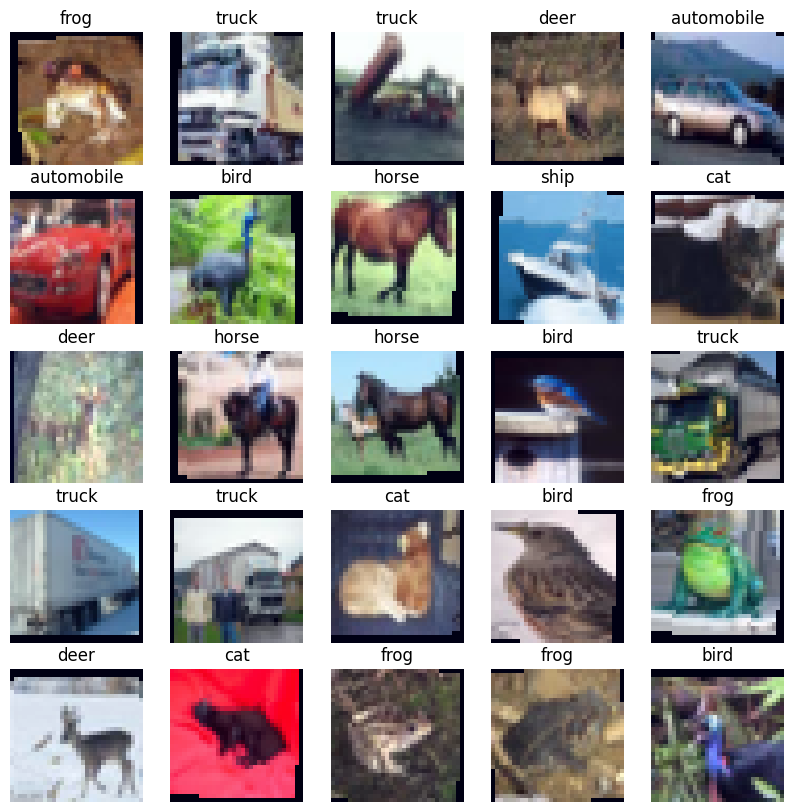

In [ ]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in
                       [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes, normalize=True)

As before, we'll check what images look like with Sobel filters applied to them.

In [ ]:
# @title Plot Filter Function
def plot_filter(images, filter, normalize=True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    filter = torch.FloatTensor(filter).unsqueeze(0).unsqueeze(0).cpu()
    filter = filter.repeat(3, 3, 1, 1)

    n_images = images.shape[0]

    filtered_images = F.conv2d(images, filter)

    images = images.permute(0, 2, 3, 1)
    filtered_images = filtered_images.permute(0, 2, 3, 1)

    fig = plt.figure(figsize=(25, 5))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(2, n_images, i+1)
        ax.imshow(image)
        ax.set_title('Original')
        ax.axis('off')

        image = filtered_images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image)
        ax.set_title('Filtered')
        ax.axis('off')

The filters are still 2-dimensional but they are expanded to a depth of three dimensions inside the `plot_filter` function.

Below is a filter which detects horizontal lines.

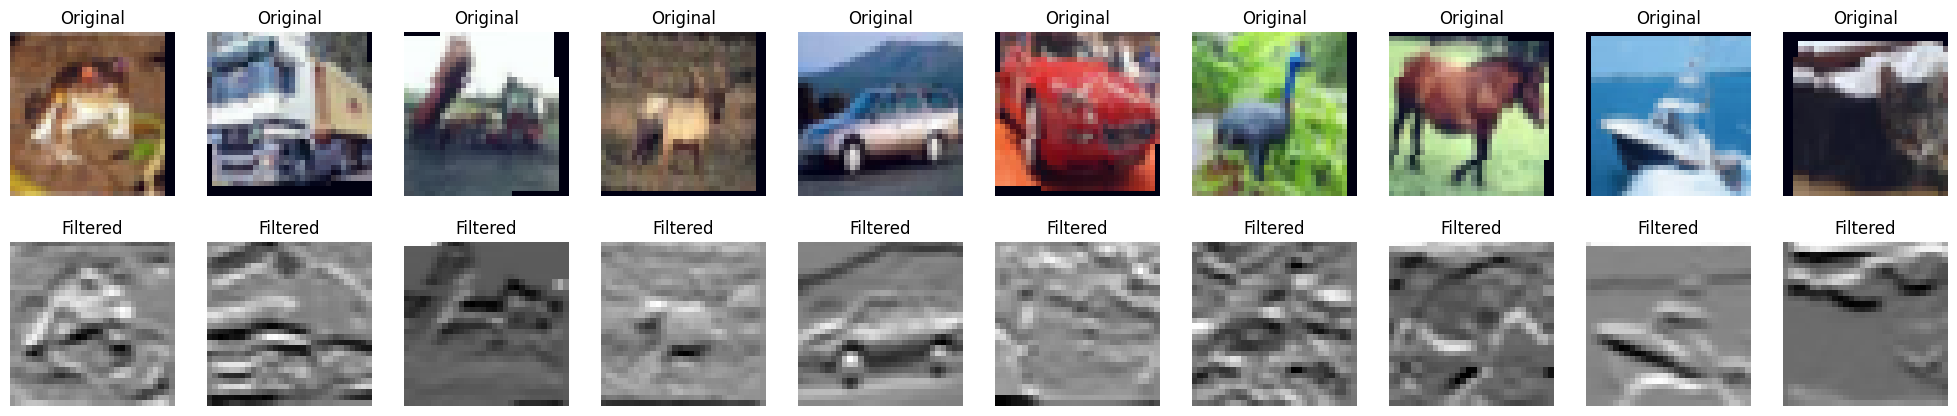

In [ ]:
N_IMAGES = 10

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]

horizontal_filter = [[-1, -2, -1],
                     [ 0,  0,  0],
                     [ 1,  2,  1]]

plot_filter(images, horizontal_filter)

Here's a filter that detects vertical lines.

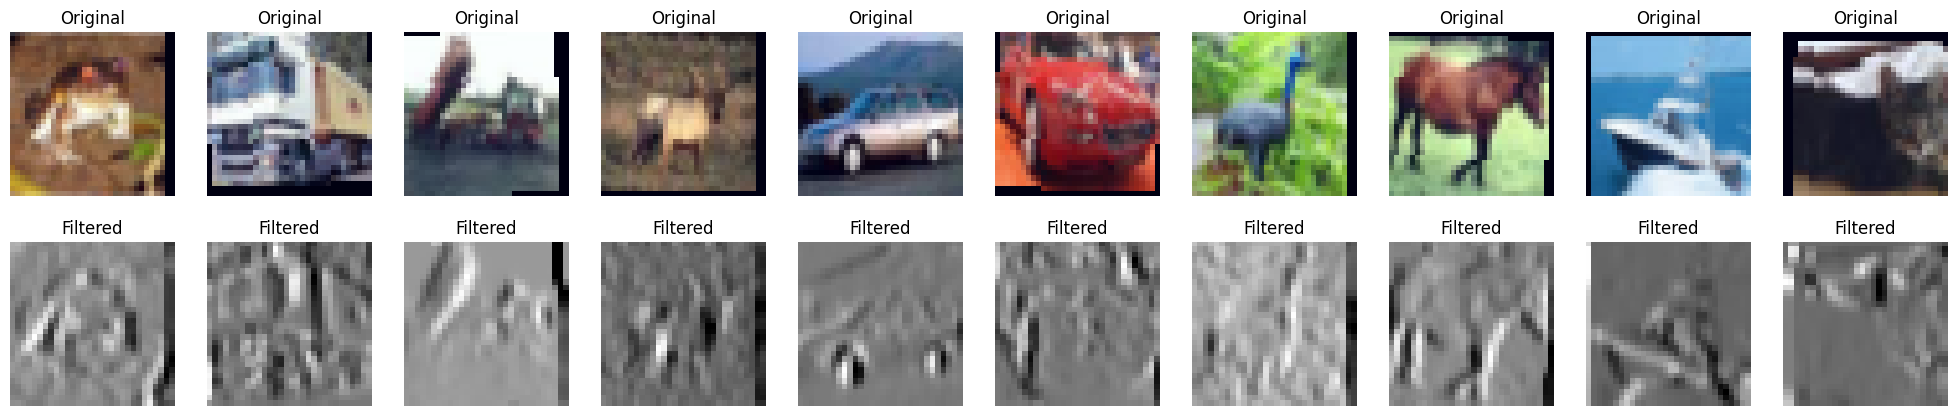

In [ ]:
vertical_filter = [[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]]

plot_filter(images, vertical_filter)

We'll also do the same for subsampling/pooling.

In [ ]:
# @title Plot Subsample Function
def plot_subsample(images, pool_type, pool_size, normalize=True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()

    if pool_type.lower() == 'max':
        pool = F.max_pool2d
    elif pool_type.lower() in ['mean', 'avg']:
        pool = F.avg_pool2d
    else:
        raise ValueError(f'pool_type must be either max or mean, got: {pool_type}')

    n_images = images.shape[0]

    pooled_images = pool(images, kernel_size=pool_size)

    images = images.permute(0, 2, 3, 1)
    pooled_images = pooled_images.permute(0, 2, 3, 1)

    fig = plt.figure(figsize=(25, 5))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(2, n_images, i+1)
        ax.imshow(image)
        ax.set_title('Original')
        ax.axis('off')

        image = pooled_images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image)
        ax.set_title('Subsampled')
        ax.axis('off')

As before, the higher filter sizes in the pooling layers means more information is lost, i.e. the image becomes lower resolution.

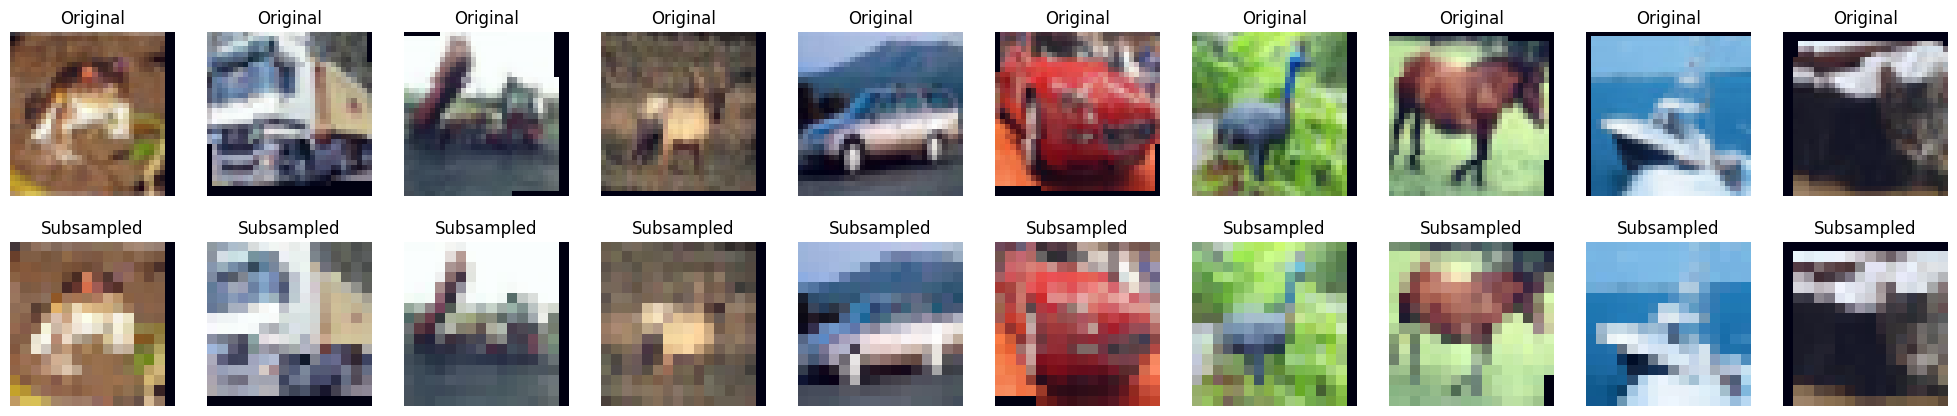

In [ ]:
plot_subsample(images, 'max', 2)

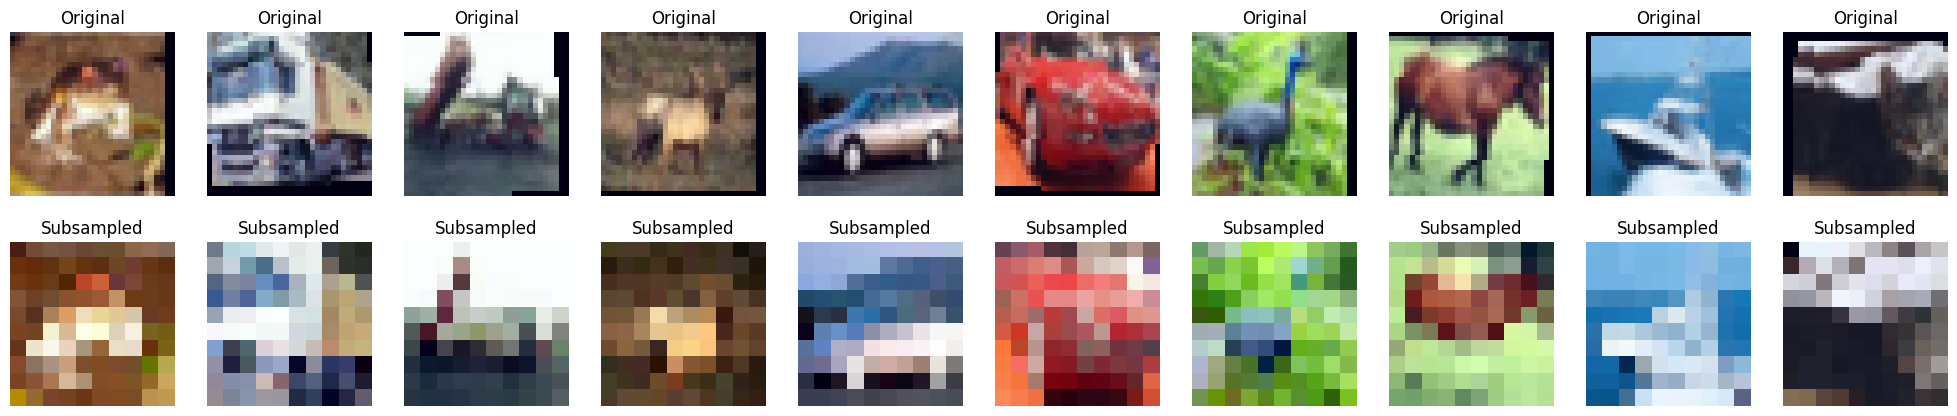

In [ ]:
plot_subsample(images, 'max', 3)

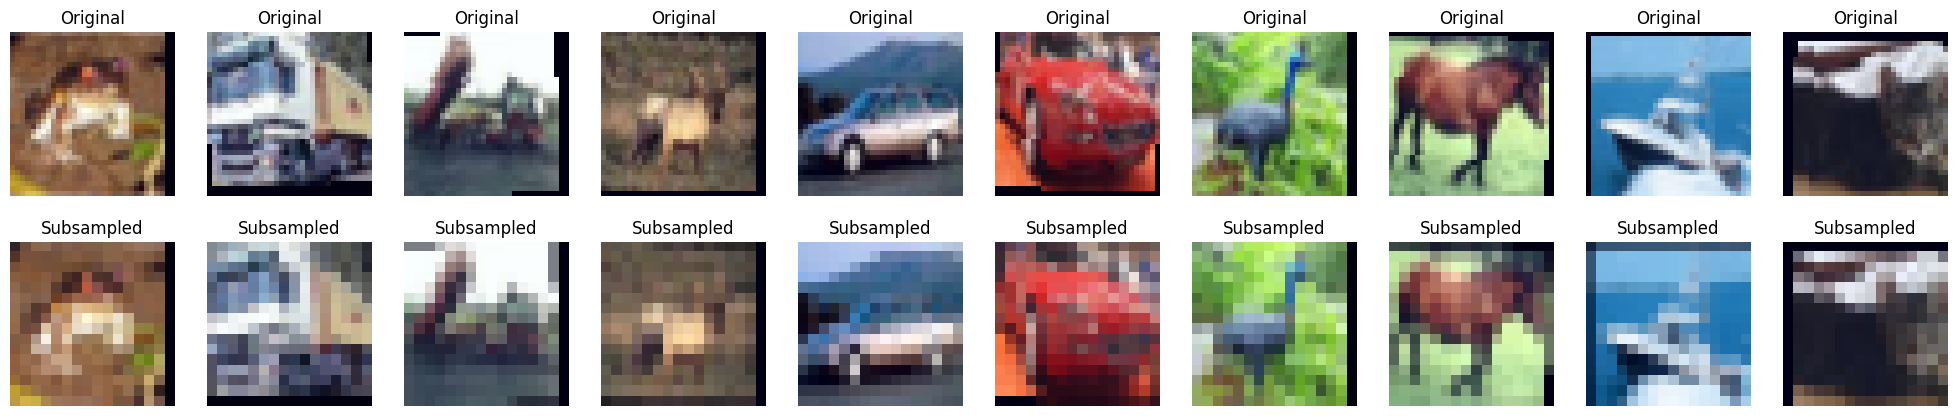

In [ ]:
plot_subsample(images, 'avg', 2)

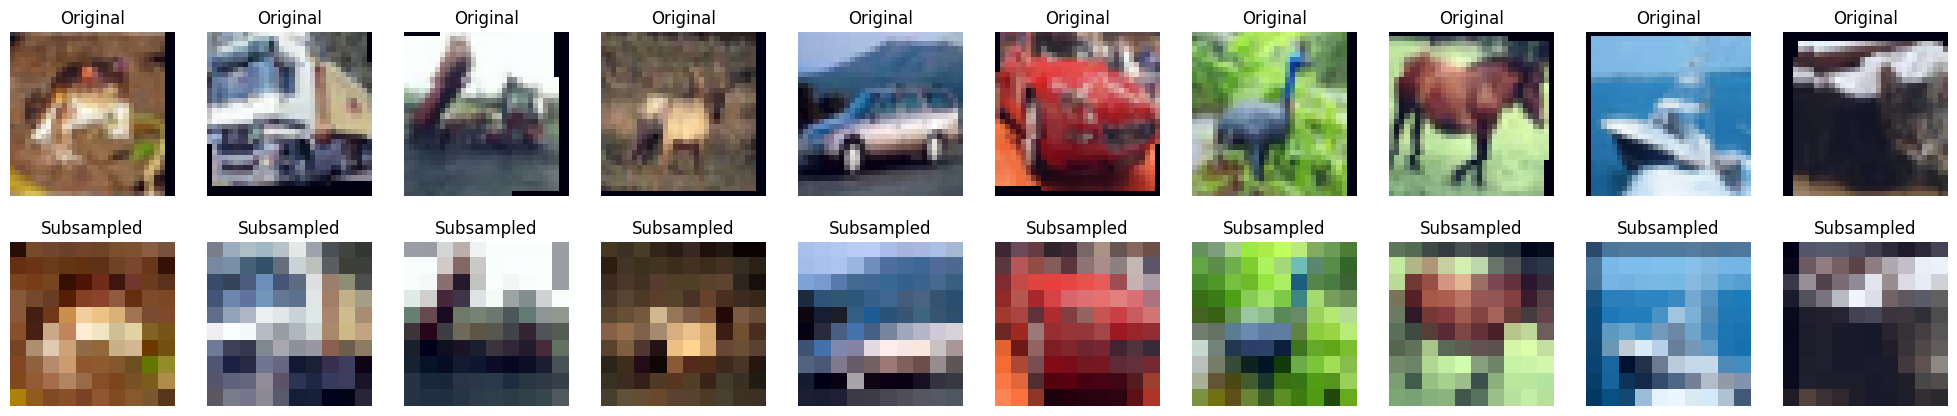

In [ ]:
plot_subsample(images, 'avg', 3)

The final bit of the data processing is creating the iterators.

We use a much larger batch size here than in previous models. Generally, when using a GPU, a larger batch size means our model trains faster. Our model has significantly more parameters and the images it is training on are much larger, than the previous notebook, so will generally take longer. We offset this as much as we can by using a batch size of 256 instead of 64.

In [ ]:
BATCH_SIZE = 256

train_loader = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

test_loader = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

---
## Define the Model



Next up is defining the model.

The actual model itself is no more difficult to understand than the previous model, LeNet. It is made up of convolutional layers, pooling layers and ReLU activation functions. See the previous notebook for a refresher on these concepts.

Dropout is a form of [*regularization*](https://en.wikipedia.org/wiki/Regularization_(mathematics)). As our models get larger, to perform more accurately on richer datasets, they start having a significantly higher number of parameters. The problem with lots of parameters is that our models begin to *overfit*. That is, they do not learn general image features whilst learning to classify images but instead simply memorize images within the training set. This is bad as it will cause our model to achieve poor performance on the validation/testing set. To solve this overfitting problem, we use regularization. Dropout is just one method of regularization, other common ones are *L1 regularization*, *L2 regularization* and *weight decay*.

Dropout works by randomly setting a certain fraction, 0.5 here, of the neurons in a layer to zero. This effectively adds noise to the training of the neural network and causes neurons to learn with "less" data as they are only getting half of the information from a previous layer with dropout applied. It can also be thought of as causing your model to learn multiple smaller models with less parameters.

Dropout is only applied when the model is training. It needs to be "turned off" when validating, testing or using the model for inference.

One last thing to mention is that the very first convolutional layer has an `in_channel` of three. That is because we are handling color images that have three channels (red, green and blue) instead of the single channel grayscale images from the MNIST dataset. This doesn't change the way any of the convolutional filter works, it just means the first filter has a depth of three instead of a depth of one.

In [ ]:
OUTPUT_DIM = 10

model = nn.Sequential(

            nn.Conv2d(3, 64, 3, 2, 1),  # in_channels, out_channels, kernel_size, stride, padding
            nn.MaxPool2d(2),  # kernel_size
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 384, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),

            nn.Flatten(),

            nn.Dropout(0.5),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, OUTPUT_DIM),
        )


Then we'll see how many trainable parameters our model has.

Our LeNet architecture had ~44k, but here we have 23.2M parameters - and AlexNet is a relatively small model for computer vision.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,272,266 trainable parameters


---
## Initialize the Parameters of the Model (Optional)





PyTorch's default initialization is usually fine. However, by manually trying different initialization schemes we can usually squeeze out a slight performance improvement. For our convolutional layers, we'll initialize the weights using *Kaiming Normal*, also known as *He Normal*. See the [paper](https://arxiv.org/abs/1502.01852) to learn more about how it was devised. For the linear layers we initialize the weights using *Xavier Normal*, also known as *Glorot Normal*. See the [paper](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) for the theory behind it.

For both types of layer we initialize the bias terms to zeros.

In [ ]:
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

We apply the initialization by using the model's `apply` method. This will call the given function on every module and sub-module within the model.

In [ ]:
model.apply(initialize_parameters)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): ReLU(inplace=True)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): ReLU(inplace=True)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Dropout(p=0.5, inplace=False)
  (15): Linear(in_features=1024, out_features=4096, bias=True)
  (16): ReLU(inplace=True)
  (17): Dropout(p=0.5, inplace=False)
  (18): Linear(in_features=4096

---
## Train and Test the Model



The rest of the notebook is pretty similar to the previous notebooks from these tutorials.

We define a function to calculate accuracy...

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# @title Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
loss_fn = loss_fn.to(device)

In [ ]:
# @title Calculate Accuracy
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

...and a function to implement our training loop.

As we are using dropout we need to make sure to "turn it on" when training by using `model.train()`.

In [ ]:
def train(model, loader, optimizer, loss_fn, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in loader:

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = loss_fn(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(loader), epoch_acc / len(loader)

Next, we define a function to tell us how long an epoch takes.

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Then, finally, we train our model.

In [ ]:
EPOCHS = 25

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_loader, optimizer, loss_fn, device)

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 35s
	Train Loss: 1.804 | Train Acc: 29.77%
Epoch: 02 | Epoch Time: 0m 34s
	Train Loss: 1.443 | Train Acc: 46.74%
Epoch: 03 | Epoch Time: 0m 34s
	Train Loss: 1.269 | Train Acc: 54.40%
Epoch: 04 | Epoch Time: 0m 33s
	Train Loss: 1.159 | Train Acc: 58.83%
Epoch: 05 | Epoch Time: 0m 33s
	Train Loss: 1.077 | Train Acc: 62.29%
Epoch: 06 | Epoch Time: 0m 34s
	Train Loss: 1.025 | Train Acc: 64.12%
Epoch: 07 | Epoch Time: 0m 33s
	Train Loss: 0.961 | Train Acc: 66.25%
Epoch: 08 | Epoch Time: 0m 34s
	Train Loss: 0.918 | Train Acc: 68.21%
Epoch: 09 | Epoch Time: 0m 34s
	Train Loss: 0.886 | Train Acc: 69.40%
Epoch: 10 | Epoch Time: 0m 33s
	Train Loss: 0.845 | Train Acc: 70.66%
Epoch: 11 | Epoch Time: 0m 34s
	Train Loss: 0.812 | Train Acc: 71.89%
Epoch: 12 | Epoch Time: 0m 33s
	Train Loss: 0.787 | Train Acc: 72.71%
Epoch: 13 | Epoch Time: 0m 34s
	Train Loss: 0.764 | Train Acc: 73.79%
Epoch: 14 | Epoch Time: 0m 34s
	Train Loss: 0.741 | Train Acc: 74.49%
Epoch: 15 | Epoch Ti

In [ ]:
torch.save(model.state_dict(), 'AlexNet-model.pt')

In [ ]:
model.load_state_dict(torch.load('AlexNet-model.pt'))

<All keys matched successfully>

Hmm, so how does our model do?

Some of the images are hard to tell if for us humans.  Still, there may be hilarious errors by our (arguably very simple CNN) model.

cat


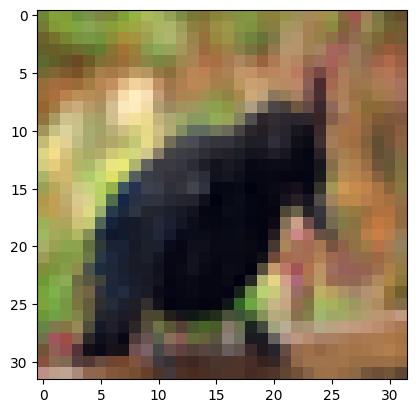

In [ ]:
test_idx = random.randint(0,len(test_data)-1)

test_img = test_data[test_idx][0]

test_img_plt = normalize_image(test_img)
plt.imshow(test_img_plt.permute(1, 2, 0).cpu().numpy())

model.eval()
with torch.no_grad():
  test_pred = model(test_img.unsqueeze_(0).to(device))
  prob = torch.softmax(test_pred, dim=-1)
  print(classes[torch.argmax(prob, 1)])




We also define an evaluation loop, making sure to "turn off" dropout with `model.eval()`.

In [ ]:
def evaluate(model, loader, loss_fn, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in loader:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = loss_fn(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(loader), epoch_acc / len(loader)

In [ ]:
test_loss, test_acc = evaluate(model, test_loader, loss_fn, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.701 | Test Acc: 76.81%
